In [1]:
import boto3
import os
from dotenv import load_dotenv
import math
import matplotlib.pyplot as plt

# Load AWS credentials and region from .env file
load_dotenv()

aws_access_key_id = os.getenv('AWS_ACCESS_KEY_ID')
aws_secret_access_key = os.getenv('AWS_SECRET_ACCESS_KEY')
region_name = os.getenv('AWS_REGION')

In [2]:
# Initialize the Textract client
client = boto3.client('textract', aws_access_key_id=aws_access_key_id, aws_secret_access_key=aws_secret_access_key, region_name=region_name)

# Specify the local image file you want to OCR
local_image_path = '../data/allweiler_page_2.png'  # Update with your actual local image path

# Read the local image
with open(local_image_path, 'rb') as image_file:
    image_binary = image_file.read()

# Call Textract to analyze the image
response = client.detect_document_text(
    Document={
        'Bytes': image_binary
    }
)

In [3]:
# Define the expected text in eight consecutive lines
expected_text = ["1", "2", "3", "4", "5", "6", "7"]

# Initialize a counter to keep track of consecutive matches
consecutive_matches = 0

# Store information about the seven lines
lines = []

block_no = 0
last_sequence_block = -1

# Iterate through the Textract response blocks
for block in response['Blocks']:
    block_no += 1
    if block['BlockType'] == 'LINE':
        text = block['Text'].strip()
        if text == expected_text[consecutive_matches]:
            consecutive_matches += 1
            lines.append(block)
            if consecutive_matches == 7:
                last_sequence_block = block_no
                print("Seven consecutive lines with the expected text were found.")
                break
        else:
            consecutive_matches = 0  # Reset the counter if the text doesn't match
            lines = []

else:
    if consecutive_matches != 7:
        print("Seven consecutive lines with the expected text were not found.")

# Save the page object
page_object = response['Blocks'][0]  # Assuming the page object is the first block

Seven consecutive lines with the expected text were found.


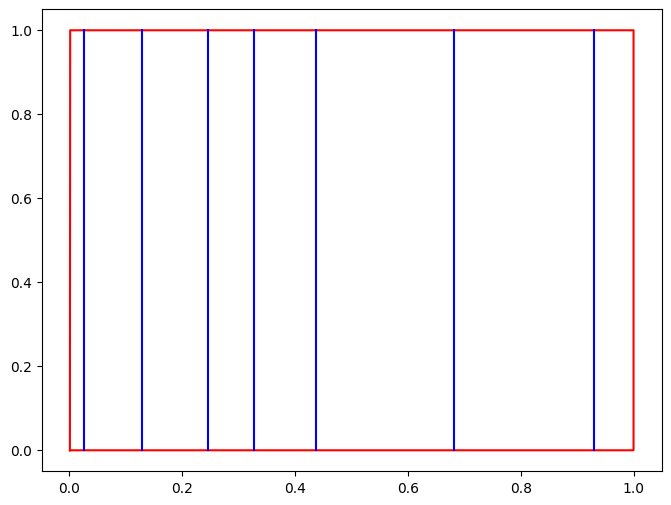

In [4]:
# Create a plot to visualize the sheet and lines
plt.figure(figsize=(8, 6))

# Plot the four corner points of the page object to create a rectangle
page_polygon = page_object['Geometry']['Polygon']
page_x = [point['X'] for point in page_polygon]
page_y = [point['Y'] for point in page_polygon]
page_x.append(page_x[0])
page_y.append(page_y[0])
plt.plot(page_x, page_y, 'r-')  # Connect the corner points in red

vertical_lines = []

for i, line in enumerate(lines):
    # Extract the bounding box coordinates from the line object
    bbox = line['Geometry']['BoundingBox']
    left = bbox['Left']
    top = bbox['Top']
    width = bbox['Width']
    height = bbox['Height']

    # Calculate the coordinates of the bounding box (just as an fyi in case it's useful somewhere else)
    x1 = left
    x2 = left + width
    y1 = 1 - top
    y2 = 1 - top + height
    # create a center x coordinate of the bounding box
    center_x = x1 + width / 2

    vertical_lines.append(center_x)

    # # Plot the bounding box
    # plt.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1])

    # Create and plot lines that extend indefinitely in both directions
    plt.plot([center_x, center_x], [0, 1], 'b-')

# # Display the image as a background
# plt.imshow(plt.imread(local_image_path), alpha=0.5)  # Alpha controls the transparency

# Show the plot
plt.show()


In [5]:
# Initialize seven groups to store LINE objects
line_groups = [[] for _ in range(7)]

for block in response['Blocks'][last_sequence_block:]:
    if block['BlockType'] == 'LINE':
        bbox = block['Geometry']['BoundingBox']
        left = bbox['Left']
        width = bbox['Width']

        # Calculate the center_x coordinate of the LINE object
        center_x = left + width / 2

        # Find the closest vertical line to the center_x
        closest_line_index = min(range(len(vertical_lines)), key=lambda i: abs(center_x - vertical_lines[i]))

        # Add the LINE object to the corresponding group
        line_groups[closest_line_index].append(block)


In [6]:
import pandas as pd

# Create a dictionary to store the resulting data
result_data = {
    'Nummer der Eintragung': [],
    'a) Firma b) Sitz c) Gegenstand des Unternehmens': [],
    'Grundkapital oder Stammkapital DM / EUR': [],
    'Vorstand, persönlich haftende Gesellschafter, Geschäftsführer, Abwickler': [],
    'Prokura': [],
    'Rechtsverhältnisse': [],
    'a) Tag der Eintragung und Unterschrift b) Bemerkungen': []
}

# Create a pandas DataFrame to store the resulting data
df = pd.DataFrame(result_data)

entry_numbers = []

# Initialize a flag to indicate whether to skip the first number for gathering divider coordinates
skip_first_number = True

# Initialize a list to store the upper y coordinates
divider_coordinates = []

# Iterate through line_group[0]
for i, block in enumerate(line_groups[0]):
    # Check if the 'Text' is a number
    if block['Text'].isdigit():
        entry_numbers.append(block['Text'])
        if skip_first_number:
            # Skip the first number
            skip_first_number = False
            continue

        # Save the upper y coordinate to the list
        divider_coordinates.append(1 - block['Geometry']['BoundingBox']['Top'])

# add entry numbers to df at the first column
df.iloc[:, 0] = entry_numbers



In [7]:
numbers_to_check = divider_coordinates

for index, list_of_blocks in enumerate(line_groups[1:]):

    remaining_objects = []

    # Initialize lists to store blocks that meet the condition
    result_lists = [[] for _ in range(len(numbers_to_check))]

    # Iterate through the blocks
    for block in list_of_blocks:
        assigned = False  # Flag to check if the block has been assigned to a list
        for i, number in enumerate(numbers_to_check):
            if 1 - block['Geometry']['BoundingBox']['Top'] > number:
                result_lists[i].append(block)
                assigned = True
                break  # Break the loop once assigned to a list

        if not assigned:
            remaining_objects.append(block)

    # Join result_lists to create strings with line breaks preserved
    joined_result_lists = ["\n".join([block['Text'] for block in result_list]) for result_list in result_lists]

    # do the same for remaining_objects
    joined_remaining_objects = "\n".join([block['Text'] for block in remaining_objects])

    # append joined reimaining objects to the end of joined result lists
    joined_result_lists.append(joined_remaining_objects)

    # add joined results list to column number index
    df.iloc[:, index+1] = joined_result_lists

In [8]:
df.to_csv('../data/allweiler_page_2.csv', index=False)